In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio
from typing import Tuple, Union
import math
import mediapipe as mp
from keras import backend as K
import sys
import random
from celluloid import Camera 
import matplotlib.pyplot as plt
from IPython.display import HTML
from moviepy.editor import ImageSequenceClip
from IPython.display import display, Image
from tensorflow.keras.models import Sequential ,model_from_json
from tensorflow.keras.layers import Conv3D,GRU, Dense, Dropout, Bidirectional, MaxPool3D, Activation, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

import keras

print(sys.executable)

c:\Users\Mgala\anaconda3\envs\tf-gpu\python.exe


# 1. Build Data Loading Functions

In [2]:
# pixels
MARGIN = 0
ROW_SIZE = 0
FONT_SIZE = 1
FONT_THICKNESS = 1

# Input model Image size
IMAGE_SIZE = (50, 100)

batch_size = 1
mp_face_mesh =  mp.solutions.face_mesh.FaceMesh(max_num_faces=1,static_image_mode=True, min_detection_confidence=0.2)


## Functions

In [3]:
def normalized_to_pixel_coordinates(normalized_x, normalized_y, image_width, image_height):
    """Converts normalized values to pixel coordinates."""
    x_px = min(max(int(normalized_x * image_width), 0), image_width)
    y_px = min(max(int(normalized_y * image_height), 0), image_height)
    return x_px, y_px

In [4]:
def contrast_based_histogram_equalization_rgb(image):
    # # Convert the image to uint8 if not already
    # if image.dtype != np.uint8:
    #     image = (image * 255).astype(np.uint8)

    # Split channels
    channels = cv2.split(image)

    # Apply histogram equalization to each channel
    equalized_channels = [cv2.equalizeHist(channel) for channel in channels]

    # Merge channels
    equalized_image = cv2.merge(equalized_channels)

    return equalized_image

def clahe_equalization_rgb(image):
    # Convert the image to LAB color space
    lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

    # Split LAB image into L, A, B channels
    l_channel, a_channel, b_channel = cv2.split(lab_image)

    # Apply CLAHE to the L channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
    clahe_l_channel = clahe.apply(l_channel)

    # Merge the enhanced L channel with the original A and B channels
    clahe_lab_image = cv2.merge((clahe_l_channel, a_channel, b_channel))

    # Convert the LAB image back to RGB
    clahe_rgb_image = cv2.cvtColor(clahe_lab_image, cv2.COLOR_LAB2RGB)

    return clahe_rgb_image

def scale_image_0_1(image):

    normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))

    return normalized_image

def scale_image__1_1(image):

    normalized_image = 2 * (image - np.min(image, axis=(0, 1))) / (np.max(image, axis=(0, 1)) - np.min(image, axis=(0, 1))) - 1
    normalized_image = np.clip(normalized_image, -1, 1)
    
    return normalized_image

def euclidean_distance(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def inner_angle(point1, point2, point3):
    a = np.array(point1)
    b = np.array(point2)
    c = np.array(point3)

    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)

    return np.degrees(angle)

def display_gif(video):
    fig, ax = plt.subplots() # make it bigger
    camera = Camera(fig)# the camera gets our figure
    for img in os.listdir("NST/epochs"):
        img_obj = plt.imread(os.path.join("NST/epochs"), img) # reading
        ax.imshow(img_obj) # plotting
        camera.snap()
    animation = camera.animate()
    HTML(animation.to_html5_video())
    clip = ImageSequenceClip(list(scale_image_0_1(video.numpy())*255), fps=20)
    clip.write_gif('test.gif', fps=20)
    return Image('test.gif')


In [5]:
def use_camera():
    cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)

    average_angle = []
    while True:
        ret, frame = cap.read()

        if not ret:
            print("Broken image")
            continue

        # Convert to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Get face mesh landmarks
        results = mp_face_mesh.process(frame_rgb)

        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                image_rows, image_cols, _ = frame.shape
                normalized_point = normalized_to_pixel_coordinates(1,1, image_cols, image_rows)

                left_lip = face_landmarks.landmark[0]
                right_lip = face_landmarks.landmark[17]
                left = face_landmarks.landmark[192]
                bottom= face_landmarks.landmark[199]
                top = face_landmarks.landmark[2]
                right = face_landmarks.landmark[416]

                bottom_px = normalized_to_pixel_coordinates(bottom.x, bottom.y, image_cols, image_rows)
                left_px = normalized_to_pixel_coordinates(left.x, left.y, image_cols, image_rows)
                top_px = normalized_to_pixel_coordinates(top.x, top.y, image_cols, image_rows)
                right_px = normalized_to_pixel_coordinates(right.x, right.y, image_cols, image_rows)
                left_lip = normalized_to_pixel_coordinates(left_lip.x, left_lip.y, image_cols, image_rows)
                right_lip = normalized_to_pixel_coordinates(right_lip.x, right_lip.y, image_cols, image_rows)


                midpoint = [(left_lip[0]+right_lip[0])//2,(left_lip[1]+right_lip[1])//2]

                # Calculate the differences in x and y coordinates
                dx = right_lip[0] - midpoint[0]
                dy = right_lip[1] - midpoint[1]
                
                # # Calculate the angle using arctan(dy/dx)
                angle_radians = math.atan2(dy, dx)
                
                # # Convert radians to degrees
                angle_degrees = math.degrees(angle_radians) - 90

                if len(average_angle) <6:
                    average_angle.append(angle_degrees)
                else:
                    average_angle.pop(0)
                    average_angle.append(angle_degrees)
                    
                if sum(average_angle) == 0:
                    angle_degrees = 0
                else:
                    angle_degrees = sum(average_angle) / len(average_angle)

                # # Rotate the image
                rotation_matrix = cv2.getRotationMatrix2D(midpoint, angle_degrees, 1.0)
                frame = cv2.warpAffine(frame, rotation_matrix, (normalized_point))

                # Convert rotated points back to list of tuples
                bottom_px , left_px , top_px , right_px = [(int(point[0][0]), int(point[0][1])) for point in cv2.transform(np.array([bottom_px , left_px , top_px , right_px]).reshape(-1, 1, 2).astype(np.float64), rotation_matrix)]

                if not (frame.shape[0] >0 and frame.shape[1] >0 and frame.shape[2] ==3):
                    continue

                frame = frame[
                        top_px[1] : bottom_px[1],
                        left_px[0] : right_px[0],
                        :,
                    ]
                
                if not (frame.shape[0] >0 and frame.shape[1] >0 and frame.shape[2] ==3):
                    continue

                frame = cv2.resize(
                        frame, (IMAGE_SIZE[1],IMAGE_SIZE[0]), interpolation=cv2.INTER_LANCZOS4
                    )
                
                frame = clahe_equalization_rgb(frame)

                mean = np.mean(frame, axis=(0, 1))  
                std = np.std(frame, axis=(0, 1))    
                frame = (frame - mean) / std
                cv2.imshow("frame", scale_image_0_1 (frame))
                break

        # Display the frame
        
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

    cap.release()
    cv2.destroyAllWindows()

# use_camera()


In [6]:
WORK_DIR = r"E:/Video Links Dataset"
FILTERED_VIDEOS = WORK_DIR + r"/filtered/videos_25fps"
FILTERED_ALIGNMENTS = WORK_DIR + r"/filtered/num_alignments"

VIDEO_DIR = os.listdir(FILTERED_VIDEOS)
ALIGNMENTS_DIR = os.listdir(FILTERED_ALIGNMENTS)

In [7]:
def get_max_letters():
    max_letters = []
    for i in ALIGNMENTS_DIR:
        with open(FILTERED_ALIGNMENTS+fr"/{i}", "r") as f:
            lines = f.readlines()
        tokens = 0
        spaces = 0
        for line in lines:
            line = line.strip("\n")
            tokens += len(line)
            spaces += 1

        max_letters.append(tokens+spaces-1)
    return max(max_letters)

MAX_LETTERS = 60
MAX_LETTERS

60

In [8]:
def get_vocab():
    letters=""
    for i in ALIGNMENTS_DIR:
        with open(FILTERED_ALIGNMENTS+fr"/{i}", "r") as f:
            content = f.read()
        for letter in content:
            if letter not in letters:
                letters  = letters + letter

    return letters

VOCAB = 'ده\nكانزميلفشغبعوترصحقضطسجخثذظء '
# VOCAB ="ابتثجحخدذرزسشصضطظعغفقكلمنهويىء٠١٢٣٤٥٦٧٨٩"
VOCAB


'ده\nكانزميلفشغبعوترصحقضطسجخثذظء '

In [9]:
set1 = set(VOCAB.replace("\n","").strip())
set2 = set("ابتثجحخدذرزسشصضطظعغفقكلمنهويء")
common_chars = set1.intersection(set2)
difference_set1 = set1.difference(set2)
difference_set2 = set2.difference(set1)

print(difference_set1, difference_set2)


set() set()


In [10]:
def get_max_frames():
    max_frames = []
    for i in VIDEO_DIR:
        cap = cv2.VideoCapture(FILTERED_VIDEOS+fr"/{i}")
        max_frames.append(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
        cap.release()
    
    return max(max_frames)
MAX_FRAMES = 138
MAX_FRAMES

138

In [11]:
def load_video(path: str) -> List[float]:
    # opens the video's path as a camera object
    cap = cv2.VideoCapture(path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # frames of the video
    frames = np.empty((MAX_FRAMES, IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    average_angle = []
    idx = 0


    # loop over all frames in the video
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        # if _ == 0:
        #     continue
        try:
            ret, frame = cap.read()
            image_rows, image_cols, _ = frame.shape
            # convert to rgb
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # get the keypoints (x,y)s of each point of a face in the frame
            face_mesh_result = mp_face_mesh.process(frame)

            # loop over each face landmark ~ (nose (x,y) lips (x,y) and so one and a bounding box)
            if face_mesh_result.multi_face_landmarks:

                for face_landmarks in face_mesh_result.multi_face_landmarks:

                    normalized_point = normalized_to_pixel_coordinates(1,1, image_cols, image_rows)

                    left_lip = face_landmarks.landmark[0]
                    right_lip = face_landmarks.landmark[17]
                    left = face_landmarks.landmark[192]
                    bottom= face_landmarks.landmark[199]
                    top = face_landmarks.landmark[2]
                    right = face_landmarks.landmark[416]

                    bottom_px = normalized_to_pixel_coordinates(bottom.x, bottom.y, image_cols, image_rows)
                    left_px = normalized_to_pixel_coordinates(left.x, left.y, image_cols, image_rows)
                    top_px = normalized_to_pixel_coordinates(top.x, top.y, image_cols, image_rows)
                    right_px = normalized_to_pixel_coordinates(right.x, right.y, image_cols, image_rows)
                    left_lip = normalized_to_pixel_coordinates(left_lip.x, left_lip.y, image_cols, image_rows)
                    right_lip = normalized_to_pixel_coordinates(right_lip.x, right_lip.y, image_cols, image_rows)


                    midpoint = [(left_lip[0]+right_lip[0])//2,(left_lip[1]+right_lip[1])//2]

                    # Calculate the differences in x and y coordinates
                    dx = right_lip[0] - midpoint[0]
                    dy = right_lip[1] - midpoint[1]
                    
                    # # Calculate the angle using arctan(dy/dx)
                    angle_radians = math.atan2(dy, dx)
                    
                    # # Convert radians to degrees
                    angle_degrees = math.degrees(angle_radians) - 90

                    if len(average_angle) <6:
                        average_angle.append(angle_degrees)
                    else:
                        average_angle.pop(0)
                        average_angle.append(angle_degrees)
                        
                    if sum(average_angle) == 0:
                        angle_degrees = 0
                    else:
                        angle_degrees = sum(average_angle) / len(average_angle)

                    # Rotate the image
                    rotation_matrix = cv2.getRotationMatrix2D(midpoint, angle_degrees, 1.0)
                    frame = cv2.warpAffine(frame, rotation_matrix, (normalized_point))

                    # Convert rotated points back to list of tuples
                    bottom_px , left_px , top_px , right_px = [(int(point[0][0]), int(point[0][1])) for point in cv2.transform(np.array([bottom_px , left_px , top_px , right_px]).reshape(-1, 1, 2).astype(np.float64), rotation_matrix)]

                    if not (frame.shape[0] >0 and frame.shape[1] >0 and frame.shape[2] ==3):
                        continue

                    frame = frame[
                            top_px[1] : bottom_px[1],
                            left_px[0] : right_px[0],
                            :,
                        ]
                    
                    if not (frame.shape[0] >0 and frame.shape[1] >0 and frame.shape[2] ==3):
                        continue

                    frame = cv2.resize(
                            frame, (IMAGE_SIZE[1],IMAGE_SIZE[0]), interpolation=cv2.INTER_LANCZOS4
                        )
                    
                    frame = clahe_equalization_rgb(frame)

                    mean = np.mean(frame, axis=(0, 1))  
                    std = np.std(frame, axis=(0, 1))    
                    frame = (frame - mean) / std

                    frames[idx] = frame

                    idx += 1
                    break

        except Exception as e:
                # Handle the case where the landmarks are not found
            print(e)
            return None

    cap.release()
    cv2.waitKey(0)

    # normalize on the scale of the video
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    frames = tf.cast((frames - mean), tf.float32) / std

    if idx < MAX_FRAMES:
        for i in range(idx, MAX_FRAMES):
            frames = tf.tensor_scatter_nd_update(frames, [[i]], tf.zeros((1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3), dtype=tf.float32))

    # frames = tf.cast(tf.convert_to_tensor(frames),tf.float32)
    
    return frames


MoviePy - Building file test.gif with imageio.


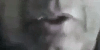

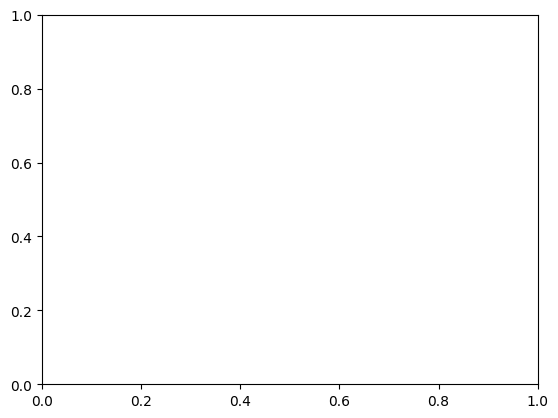

In [12]:
display_gif(load_video(FILTERED_VIDEOS + fr"/{VIDEO_DIR[0]}"))

MoviePy - Building file test.gif with imageio.


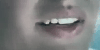

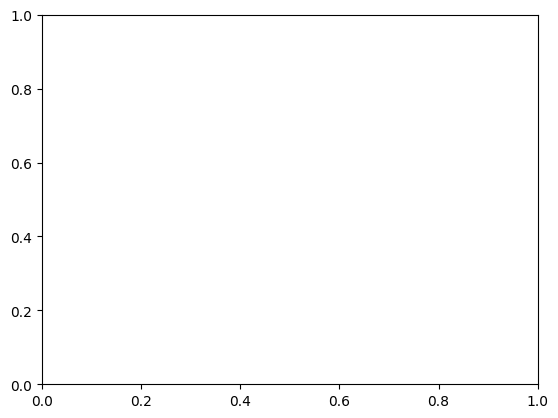

In [13]:
display_gif(load_video(FILTERED_VIDEOS + fr"/{VIDEO_DIR[100]}"))

MoviePy - Building file test.gif with imageio.


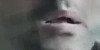

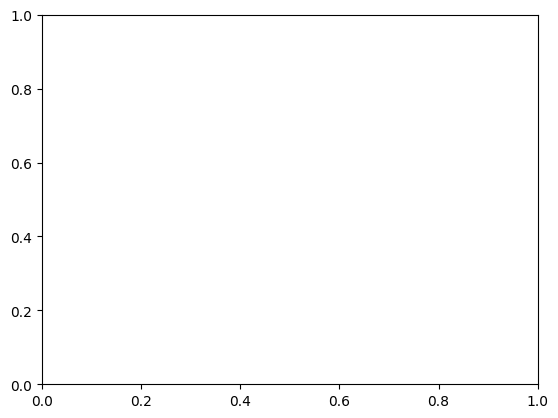

In [14]:
display_gif(load_video(FILTERED_VIDEOS + fr"/{VIDEO_DIR[200]}"))

MoviePy - Building file test.gif with imageio.


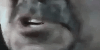

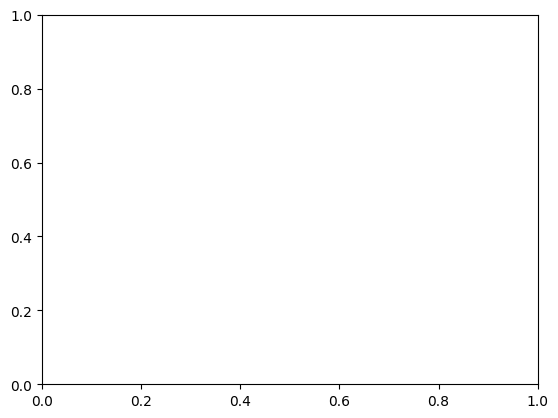

In [15]:
display_gif(load_video(FILTERED_VIDEOS + fr"/{VIDEO_DIR[300]}"))

MoviePy - Building file test.gif with imageio.


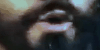

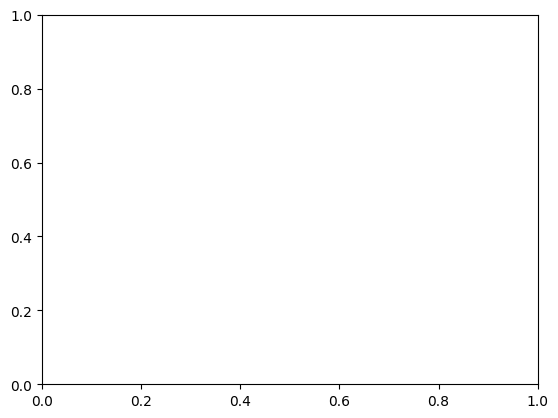

In [16]:
display_gif(load_video(FILTERED_VIDEOS + fr"/{VIDEO_DIR[1200]}"))

MoviePy - Building file test.gif with imageio.


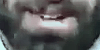

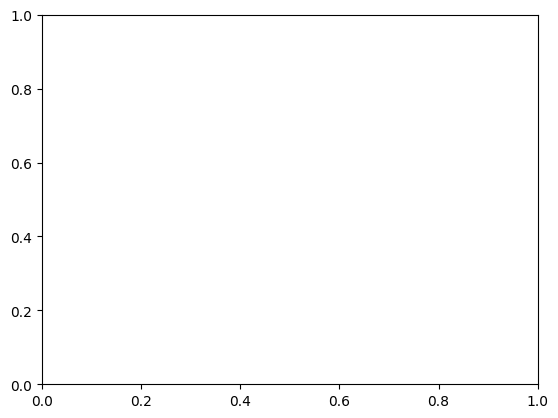

In [17]:
x = load_video(FILTERED_VIDEOS + fr"/{VIDEO_DIR[-1]}")
display_gif(x)

In [18]:
x.shape

TensorShape([138, 50, 100, 3])

In [19]:
x.numpy().max(), x.numpy().min(), x.dtype

(4.8180833, -2.6701813, tf.float32)

In [20]:
vocab = [x for x in "ابتثجحخدذرزسشصضطظعغفقكلمنهويء "]

In [21]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'ا', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ي', 'ء', ' '] (size =31)


In [22]:
char_to_num.get_vocabulary()

['',
 'ا',
 'ب',
 'ت',
 'ث',
 'ج',
 'ح',
 'خ',
 'د',
 'ذ',
 'ر',
 'ز',
 'س',
 'ش',
 'ص',
 'ض',
 'ط',
 'ظ',
 'ع',
 'غ',
 'ف',
 'ق',
 'ك',
 'ل',
 'م',
 'ن',
 'ه',
 'و',
 'ي',
 'ء',
 ' ']

In [23]:
def char_to_arab(alignments):
    sub_arrays = []
    current_sub_array = []
    for element in num_to_char(alignments).numpy():
        if element.decode("utf-8") == "":
            if current_sub_array:  # Add a non-empty sub-array
                sub_arrays.append(current_sub_array)
            current_sub_array = []  # Start a new sub-array
        else:
            current_sub_array.append(element.decode("utf-8"))

    if current_sub_array:  # Add the last sub-array if it's not empty
        sub_arrays.append(current_sub_array)

    for i in sub_arrays:
        print(''.join(i),end=" ")

In [24]:
char_to_num(["","ا", "ن", "ا", " ", "ا", "ن", "ا", ""])

<tf.Tensor: shape=(9,), dtype=int64, numpy=array([ 0,  1, 25,  1, 30,  1, 25,  1,  0], dtype=int64)>

In [25]:
char_to_arab([1, 25, 1,0, 1, 25, 1])

انا انا 

In [26]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.strip("\n")
        tokens = [*tokens,' ',line]

    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [27]:
label = load_alignments(FILTERED_ALIGNMENTS + fr"/{ALIGNMENTS_DIR[100]}")
label, char_to_arab(label)

اسمها منيو اجري علي الله 

(<tf.Tensor: shape=(24,), dtype=int64, numpy=
 array([ 1, 12, 24, 26,  1, 30, 24, 25, 28, 27, 30,  1,  5, 10, 28, 30, 18,
        23, 28, 30,  1, 23, 23, 26], dtype=int64)>,
 None)

In [28]:
def load_data(path: str): 

    path = bytes.decode(path.numpy())
    
    file_name = path.replace("\\","/").split('/')[-1].split('.')[0]
    video_path = FILTERED_VIDEOS + fr'/{file_name}.mp4'
    alignment_path = FILTERED_ALIGNMENTS + fr'/{file_name}.align'

    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [29]:
test_path = FILTERED_VIDEOS + fr"/{VIDEO_DIR[-1]}"

In [30]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'9_13'

In [31]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

MoviePy - Building file test.gif with imageio.


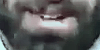

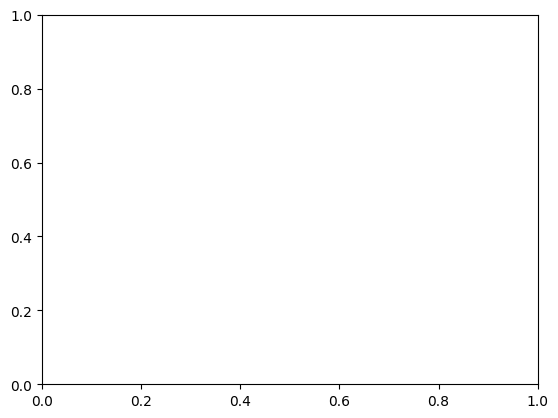

In [32]:
display_gif(frames)

In [33]:
char_to_arab(alignments)

واحده ان شاء الله باذن الله فخليني اسال 

In [34]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [35]:
if not os.path.exists(r"shuffle.txt"):

    filtered_videos_path = FILTERED_VIDEOS
    shuffled_order_file = "shuffle.txt"

    data = tf.data.Dataset.list_files(filtered_videos_path + r"/*.mp4")

    data = data.shuffle(500, reshuffle_each_iteration=False)

    shuffled_file_paths = list(data.as_numpy_iterator())

    with open(shuffled_order_file, 'w') as f:
        for path in shuffled_file_paths:
            f.write(path.decode('utf-8') + '\n')

In [36]:
shuffled_order_file = "shuffle.txt"

with open(shuffled_order_file, 'r') as f:
    shuffled_file_paths = f.read().splitlines()

data = tf.data.Dataset.from_tensor_slices(shuffled_file_paths)

num_files = len(shuffled_file_paths)

train_size = int(0.8 * num_files)
val_size = int(0.1 * num_files)
test_size = num_files - train_size - val_size

train_data = data.take(train_size)
val_test_data = data.skip(train_size)
val_data = val_test_data.take(val_size)
test_data = val_test_data.skip(val_size)


train_data = train_data.map(mappable_function)
train_data = train_data.padded_batch(
    batch_size, padded_shapes=([MAX_FRAMES, None, None, None], [MAX_LETTERS])
)
train_data = train_data.prefetch(tf.data.AUTOTUNE)

val_data = val_data.map(mappable_function)
val_data = val_data.padded_batch(
    batch_size, padded_shapes=([MAX_FRAMES, None, None, None], [MAX_LETTERS])
)
val_data = val_data.prefetch(tf.data.AUTOTUNE)

test_data = test_data.map(mappable_function)
test_data = test_data.padded_batch(
    batch_size, padded_shapes=([MAX_FRAMES, None, None, None], [MAX_LETTERS])
)
test_data = test_data.prefetch(tf.data.AUTOTUNE)


In [37]:
char_to_num.vocabulary_size()

31

In [38]:
frames, alignments = train_data.as_numpy_iterator().next()

In [39]:
frames[0].shape

(138, 50, 100, 3)

In [40]:
sample = train_data.as_numpy_iterator()

In [41]:
val = sample.next()

val[1][0].shape,val[0][0].shape

((60,), (138, 50, 100, 3))

In [42]:
val[0].shape

(1, 138, 50, 100, 3)

In [43]:
val[1][0]

array([20, 28, 30,  3, 16,  2, 28, 21, 30, 24,  2,  8,  1, 30,  1, 23, 27,
       10,  1,  4, 26, 30, 20, 28, 30,  1, 23,  6, 22, 24, 30, 23, 24,  8,
       26,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int64)

In [44]:
char_to_arab(val[1][0])

في تطبيق مبدا الوراثه في الحكم لمده 

# 3. Design the Deep Neural Network

In [45]:
train_data.as_numpy_iterator().next()[0][0].shape

(138, 50, 100, 3)

In [46]:
char_to_num.vocabulary_size()

31

In [47]:
model = Sequential()
model.add(Conv3D(16,(1, 5, 5),strides=(1,2,2), input_shape=(MAX_FRAMES, IMAGE_SIZE[0],IMAGE_SIZE[1], 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(32,(1, 5, 5), padding="same"))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(64,(1, 3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(GRU(32,kernel_initializer=keras.initializers.Orthogonal(), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(GRU(32,kernel_initializer=keras.initializers.Orthogonal(), return_sequences=True)))
model.add(Dropout(0.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [48]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 138, 25, 50, 32)   2432      
                                                                 
 activation (Activation)     (None, 138, 25, 50, 32)   0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 138, 12, 25, 32)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 138, 12, 25, 64)   51264     
                                                                 
 activation_1 (Activation)   (None, 138, 12, 25, 64)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 138, 6, 12, 64)   0         
 3D)                                                    

In [49]:
yhat = model.predict(val[0])

1/1 [==============================] - 4s 4s/step


In [50]:
val[0].shape

(1, 138, 50, 100, 3)

In [51]:
yhat.shape

(1, 138, 32)

In [52]:
yhat[0].shape

(138, 32)

In [53]:
char_to_arab(tf.argmax(yhat[0], axis=1).numpy())

ثططططططططططططططططططططططططططططططططططططططططططططططططططططططططططططططططططططططططططططءءءءءءءءءءققااااااا 

In [54]:
model.input_shape

(None, 138, 50, 100, 3)

In [55]:
model.output_shape

(None, 138, 32)

# 4. Setup Training Options and Train

In [56]:
def CTCLoss(y_true, y_pred):
    # y_true = tf.cast(y_true,tf.int64)
    # y_pred =  tf.cast(y_pred,tf.int64)
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost( y_true,y_pred, input_length, label_length)
    return loss

In [57]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.sample = train_data.as_numpy_iterator().next()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.sample
        yhat = self.model.predict(data[0],verbose=0)  # [75,75]

        decoded_200 = tf.keras.backend.ctc_decode(yhat, [MAX_FRAMES], greedy=False,beam_width=200)[0][0].numpy()
        decoded_100 = tf.keras.backend.ctc_decode(yhat, [MAX_FRAMES], greedy=False,beam_width=100)[0][0].numpy()
        decoded_50 = tf.keras.backend.ctc_decode(yhat, [MAX_FRAMES], greedy=False,beam_width=50)[0][0].numpy()
        decoded_letter = tf.keras.backend.ctc_decode(yhat, [MAX_FRAMES], greedy=False,beam_width=char_to_num.vocabulary_size()+1)[0][0].numpy()
        decoded_40 = tf.keras.backend.ctc_decode(yhat, [MAX_FRAMES], greedy=False,beam_width=40)[0][0].numpy()
        decoded_30 = tf.keras.backend.ctc_decode(yhat, [MAX_FRAMES], greedy=False,beam_width=30)[0][0].numpy()
        decoded_20 = tf.keras.backend.ctc_decode(yhat, [MAX_FRAMES], greedy=False,beam_width=20)[0][0].numpy()
        decoded_10 = tf.keras.backend.ctc_decode(yhat, [MAX_FRAMES], greedy=False,beam_width=10)[0][0].numpy()
        decoded_5 = tf.keras.backend.ctc_decode(yhat, [MAX_FRAMES], greedy=False,beam_width=5)[0][0].numpy()
        decoded_1 = tf.keras.backend.ctc_decode(yhat, [MAX_FRAMES], greedy=False,beam_width=1)[0][0].numpy()
        decoded_1_greedy = tf.keras.backend.ctc_decode(yhat, [MAX_FRAMES], greedy=True)[0][0].numpy()

        for x in range(len(yhat)):
            print("\n\n")
            print("Original:",tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode("utf-8"))
            print("Prediction Dec 200:",tf.strings.reduce_join(num_to_char(decoded_200[x])).numpy().decode("utf-8"))
            print("Prediction Dec 100:",tf.strings.reduce_join(num_to_char(decoded_100[x])).numpy().decode("utf-8"))
            print("Prediction Dec 50:",tf.strings.reduce_join(num_to_char(decoded_50[x])).numpy().decode("utf-8"))
            print("Prediction Dec Voc:",tf.strings.reduce_join(num_to_char(decoded_letter[x])).numpy().decode("utf-8"))
            print("Prediction Dec 40:",tf.strings.reduce_join(num_to_char(decoded_40[x])).numpy().decode("utf-8"))
            print("Prediction Dec 30:",tf.strings.reduce_join(num_to_char(decoded_30[x])).numpy().decode("utf-8"))
            print("Prediction Dec 20:",tf.strings.reduce_join(num_to_char(decoded_20[x])).numpy().decode("utf-8"))
            print("Prediction Dec 10:",tf.strings.reduce_join(num_to_char(decoded_10[x])).numpy().decode("utf-8"))
            print("Prediction Dec 5:",tf.strings.reduce_join(num_to_char(decoded_5[x])).numpy().decode("utf-8"))
            print("Prediction Dec 1:",tf.strings.reduce_join(num_to_char(decoded_1[x])).numpy().decode("utf-8"))
            print("Prediction Dec Greedy:",tf.strings.reduce_join(num_to_char(decoded_1_greedy[x])).numpy().decode("utf-8"))
            print("\n\n")

In [58]:
checkpoint_callback = ModelCheckpoint(os.path.join('checkpoints','test2_num_small.hdf5'), monitor='val_loss',
                                       save_weights_only=True,mode='min',save_freq='epoch') 
example_callback = ProduceExample(data)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',  
            patience=100,
            restore_best_weights=True,
        )

In [59]:
class CERMetric(tf.keras.metrics.Metric):
    """
    A custom Keras metric to compute the Character Error Rate
    """
    def __init__(self, name='CER_metric', **kwargs):
        super(CERMetric, self).__init__(name=name, **kwargs)
        self.cer_accumulator = self.add_weight(name="total_cer", initializer="zeros")
        self.counter = self.add_weight(name="cer_count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):

        input_shape = K.shape(y_pred)
        input_length = tf.ones(shape=input_shape[0], dtype=tf.int64) * K.cast(input_shape[1], tf.int64)

        decode, log = K.ctc_decode(y_pred,
                                    input_length,
                                    greedy=True)

        decode = K.ctc_label_dense_to_sparse(decode[0], K.cast(input_length, tf.int32))
        y_true_sparse = K.ctc_label_dense_to_sparse(y_true, K.cast(input_length, tf.int32))

        decode = tf.sparse.retain(decode, tf.not_equal(decode.values, -1))
        distance = tf.edit_distance(decode, y_true_sparse, normalize=True)

        self.cer_accumulator.assign_add(tf.reduce_sum(distance))
        self.counter.assign_add(tf.cast(tf.shape(y_true)[0], tf.float32))

    def result(self):
        return tf.math.divide_no_nan(self.cer_accumulator, self.counter)

    def reset_states(self):
        self.cer_accumulator.assign(0.0)
        self.counter.assign(0.0)

In [60]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001),
              metrics=[CERMetric()], 
              loss=CTCLoss)

In [61]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10000,
    callbacks=[
        example_callback,
        early_stopping_callback,
        checkpoint_callback
    ],
    batch_size=batch_size,
)

Epoch 1/10000


2295/2295 [==============================] - ETA: 0s - loss: 120.5641 - CER_metric: 0.5566


Original: في تطبيق مبدا الوراثه في الحكم لمده
Prediction Dec 200: ا ا ا ا ا ا ا ا ا ا 
Prediction Dec 100: ا ا ا ا ا ا ا ا ا ا 
Prediction Dec 50: ا ا ا ا ا ا ا ا ا ا 
Prediction Dec Voc: ا ا ا ا ا ا ا ا ا ا 
Prediction Dec 40: ا ا ا ا ا ا ا ا ا ا 
Prediction Dec 30: ا ا ا ا ا ا ا ا ا ا 
Prediction Dec 20: ا ا ا ا ا ا ا ا ا ا 
Prediction Dec 10: ا ا ا ا ا ا ا ا ا 
Prediction Dec 5: ا ا ا ا ا ا ا ا ا 
Prediction Dec 1: ا 
Prediction Dec Greedy: ا 



2295/2295 [==============================] - 4127s 2s/step - loss: 120.5641 - CER_metric: 0.5566 - val_loss: 112.4564 - val_CER_metric: 0.9501
Epoch 2/10000
2295/2295 [==============================] - ETA: 0s - loss: 112.3128 - CER_metric: 0.5329


Original: في تطبيق مبدا الوراثه في الحكم لمده
Prediction Dec 200: ا ا ا ا ا ا ا ا ا ا 
Prediction Dec 100: ا ا ا ا ا ا ا ا ا ا 
Prediction Dec 50: ا ا ا ا ا ا ا ا ا ا 
Prediction Dec Voc: ا ا ا ا ا ا ا ا

KeyboardInterrupt: 

In [204]:
model.load_weights("checkpoints/test2_num.hdf5")

In [ ]:
testing_metrics = model.evaluate(test_data)
testing_metrics